In [212]:
from sqlalchemy import create_engine, text, inspect
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [213]:
# Variables globales
engine = None

def connect_to_db():
    global engine
    user = 'root'
    password = 'rootpassword'
    host = '127.0.0.1'
    port = 3309
    db = 'AIRQUALITY'

    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(connection_string)
    print("✅ Conexión a MySQL creada.")


In [214]:
def load_all_dataframes_from_db():
    if engine is None:
        raise Exception("Primero debes ejecutar `connect_to_db()` para establecer la conexión.")

    try:
        DFAQSEP = pd.read_sql("SELECT * FROM DF_AQ_SEP", con=engine)
        DFAQ1 = pd.read_sql("SELECT * FROM DF_AQ_1", con=engine)
        DFAQ2 = pd.read_sql("SELECT * FROM DF_AQ_2", con=engine)

        print("✅ Datos cargados correctamente desde la base de datos.")
        return DFAQSEP, DFAQ1, DFAQ2

    except Exception as e:
        print(f"❌ Error al cargar los datos: {e}")
        return None, None, None


In [215]:
# Primero conectas a la BD
connect_to_db()

# Luego cargas los datos
DFAQSEP, DFAQ1, DFAQ2 = load_all_dataframes_from_db()

✅ Conexión a MySQL creada.
✅ Datos cargados correctamente desde la base de datos.


In [216]:
print(DFAQSEP.head())
print(DFAQ1.head())
print(DFAQ2.head())

   pm2_5  pm10    co   o3   pm5  humidity  temperature          time_format
0    0.6   0.6  33.6  0.1  None       NaN         14.6  2024-03-15 22:26:36
1    0.3   0.3  12.2  0.1  None       NaN          9.5  2024-03-18 02:11:58
2    0.3   0.3  16.1  0.1  None       NaN          8.5  2024-03-18 04:57:01
3    0.6   0.6  24.9  0.4  None       NaN         21.0  2024-03-19 17:12:33
4    0.7   0.8  31.8  0.2  None       NaN         17.4  2024-03-26 18:30:02
   pm2_5  pm10  co  o3  humidity  temperature  pm5          time_format
0     48    65   7 NaN      61.2         20.2   31  2024-04-08 20:22:00
1      5     6  30 NaN      64.4         19.8    3  2024-04-10 00:00:00
2      7     7   8 NaN      64.6         19.8    4  2024-04-10 00:18:00
3      3     3   4 NaN      66.1         19.9    2  2024-04-10 02:19:00
4      3     3  25 NaN      67.2         19.9    2  2024-04-10 04:07:00
   pm2_5  pm10  co  o3  humidity  temperature  pm5          time_format
0     20    25  14 NaN      69.4        

In [217]:
def remove_outliers_and_plot_boxplot(df, column, iqr_factor=1.4):
    """
    Elimina outliers de un DataFrame con base en la columna indicada,
    usando el método IQR, y grafica un boxplot con los cuartiles ajustados.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
        column (str): nombre de la columna a procesar
        iqr_factor (float): multiplicador del IQR para definir límites (default 1.4)

    Retorna:
        pd.DataFrame: nuevo DataFrame sin outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    Q1_filtered = df_filtered[column].quantile(0.25)
    Q3_filtered = df_filtered[column].quantile(0.75)

    print(f"👉 Columna: {column}")
    print(f"📊 Registros antes: {df.shape[0]}")
    print(f"✅ Registros después de remover outliers: {df_filtered.shape[0]}")

    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_filtered[column])
    plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
    plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
    plt.title(f'Boxplot de {column.upper()} con Cuartiles Ajustados')
    plt.ylabel('Concentración (µg/m³)')
    plt.legend()
    plt.show()

    return df_filtered


In [218]:
def plot_correlation_map(df, title="Mapa de Correlaciones", figsize=(10, 8), cmap="coolwarm"):
    """
    Genera un mapa de calor con la matriz de correlaciones del DataFrame.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
        title (str): Título del gráfico
        figsize (tuple): Tamaño del gráfico
        cmap (str): Paleta de colores del heatmap

    Retorna:
        None
    """
    # Filtrar solo columnas numéricas
    numeric_df = df.select_dtypes(include='number')

    if numeric_df.shape[1] < 2:
        print("⚠️ El DataFrame debe tener al menos dos columnas numéricas para calcular correlaciones.")
        return

    # Calcular matriz de correlación
    corr = numeric_df.corr()

    # Graficar heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [343]:
def plot_correlation_map(
    df,
    cols=None,
    order=None,
    cmap="coolwarm",
    annot=True,
    figsize=(8,6),
    xlabels=None,   # nuevo: etiquetas personalizadas para eje X
    ylabels=None,   # nuevo: etiquetas personalizadas para eje Y
    xrotation=30,   # nuevo: rotación eje X (0=horizontal)
    fontsize=10     # nuevo: tamaño de fuente
):
    """
    Grafica un mapa de correlación con control sobre etiquetas y rotación.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    cols : list[str], opcional
        Lista de columnas a incluir en el mapa de correlación.
    order : list[str], opcional
        Orden específico de las columnas en el mapa.
    cmap : str, opcional
        Paleta de colores.
    annot : bool, opcional
        Si True, muestra los valores numéricos de la correlación.
    figsize : tuple, opcional
        Tamaño de la figura en pulgadas.
    xlabels, ylabels : list[str], opcional
        Etiquetas personalizadas para los ejes X e Y.
    xrotation : int, opcional
        Rotación de etiquetas en el eje X.
    fontsize : int, opcional
        Tamaño de fuente para etiquetas.
    """
    # Selección de columnas
    if cols is not None:
        df_sel = df[cols]
    else:
        df_sel = df.select_dtypes(include="number")

    # Reordenamiento si se especifica
    if order is not None:
        df_sel = df_sel[order]

    # Calcular correlaciones
    corr = df_sel.corr()

    # Graficar
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        center=0,
        linewidths=0.5,
        fmt=".2f",
        cbar_kws={"shrink": .8}
    )

    # Personalizar etiquetas del eje X e Y
    n = len(corr.columns)
    if xlabels is None:
        xlabels = corr.columns
    if ylabels is None:
        ylabels = corr.index

    ax.set_xticks(np.arange(n) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)

    ax.set_xticklabels(xlabels, rotation=xrotation, ha="right", fontsize=fontsize, fontweight="bold")
    ax.set_yticklabels(ylabels, rotation=0, ha="right", fontsize=fontsize, fontweight="bold")

    # Título
    ax.set_title("Mapa de correlación", fontsize=14, pad=12, fontweight="bold")

    plt.tight_layout()
    plt.show()


In [336]:
def plot_all_boxplots(
    df,
    columns=None,
    title="Boxplot de variables numéricas",
    figsize=(12, 6),
    column_order=None,   # nuevo: orden explícito
    xlabels=None,        # nuevo: etiquetas personalizadas para eje X
    bold_xticks=True,    # nuevo: poner etiquetas en negrita
    rotate_xticks=0,     # nuevo: rotación opcional
    show_grid=True       # nuevo: activar/desactivar grid
):
    """
    Genera un boxplot para columnas numéricas específicas de un DataFrame,
    permitiendo definir orden y etiquetas personalizadas.
    """

    # 1) Candidatas: todas las numéricas si no se pasan columnas
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    else:
        # mantén solo las que existan en el df y sean numéricas
        columns = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    if not columns:
        print("⚠️ No hay columnas válidas (numéricas) para graficar.")
        return

    # 2) Orden final de columnas
    if column_order is not None:
        # Mantener el orden solicitado pero filtrando a numéricas válidas
        ordered = [c for c in column_order if c in columns]
        missing = [c for c in column_order if c not in columns]
        if missing:
            print(f"ℹ️ Se ignoraron columnas no numéricas o inexistentes: {missing}")
        if ordered:
            columns = ordered

    # 3) Long format + asegurar orden categórico
    df_melted = df.melt(value_vars=columns, var_name="Variable", value_name="Valor")
    df_melted["Variable"] = pd.Categorical(df_melted["Variable"], categories=columns, ordered=True)

    # 4) Graficar
    plt.figure(figsize=figsize)
    ax = sns.boxplot(x="Variable", y="Valor", data=df_melted, order=columns)

    # 5) Etiquetas eje X (personalizadas y/o en negrita)
    if xlabels is not None:
        if len(xlabels) != len(columns):
            raise ValueError("xlabels debe tener la misma longitud que las columnas a graficar.")
        ax.set_xticklabels(xlabels, rotation=rotate_xticks, ha="center",
                           fontweight=("bold" if bold_xticks else None))
    else:
        ax.set_xticklabels(columns, rotation=rotate_xticks, ha="center",
                           fontweight=("bold" if bold_xticks else None))

    # 6) Títulos y estilos
    ax.set_title(title, fontweight='bold', pad=12)
    ax.set_xlabel("Variables")
    ax.set_ylabel("Valores")
    if show_grid:
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()


In [221]:
def resample_dataframe_by_time(df, time_column='time_format', freq='H', agg_func='median'):
    """
    Realiza un resampleo temporal de un DataFrame según el índice temporal.

    Parámetros:
        df (pd.DataFrame): DataFrame original con columna de tiempo
        time_column (str): Nombre de la columna de tiempo (por defecto 'time_format')
        freq (str): Frecuencia de resampleo (por defecto 'H' = hora)
        agg_func (str): Función de agregación: 'mean', 'median', 'sum', etc.

    Retorna:
        pd.DataFrame: DataFrame resampleado
    """
    df_copy = df.copy()


    # Asegúrate de que 'time_format' esté en formato datetime
    df_copy[time_column] = pd.to_datetime(df_copy[time_column])

    # Establecer la columna 'time_format' como índice
    df_copy.set_index(time_column, inplace=True)

    # Realizar resampleo con la función agregada
    if agg_func == 'median':
        df_resampled = df_copy.resample(freq).median()
    elif agg_func == 'mean':
        df_resampled = df_copy.resample(freq).mean()
    elif agg_func == 'sum':
        df_resampled = df_copy.resample(freq).sum()
    else:
        raise ValueError("Función de agregación no soportada. Usa: 'mean', 'median', 'sum'.")

    return df_resampled


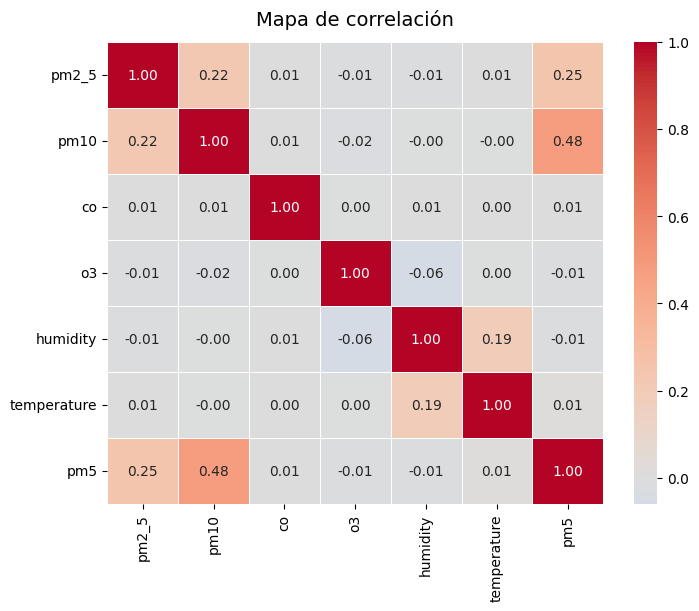

In [222]:
plot_correlation_map(DFAQ2)

In [223]:
## ---------------------- NUEVAS FUNCIONES ------------------

In [224]:
def limitar_umbrales_columna(
    df: pd.DataFrame,
    col: str,
    method: str = "fixed",
    lower: float | None = None,
    upper: float | None = None,
    iqr_k: float = 1.5,
    return_report: bool = True,
    inplace: bool = False
):
    """
    Limita una columna a umbrales inferior/superior y marca como NaN los valores fuera de rango,
    sin eliminar filas.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original.
    col : str
        Nombre de la columna a limpiar.
    method : {"fixed", "iqr"}, por defecto "fixed"
        - "fixed": usa `lower` y/o `upper` provistos por el usuario.
        - "iqr": calcula umbrales con IQR: [Q1 - iqr_k*IQR, Q3 + iqr_k*IQR].
    lower : float | None
        Umbral inferior (solo para method="fixed"). Si None, no se aplica límite inferior.
    upper : float | None
        Umbral superior (solo para method="fixed"). Si None, no se aplica límite superior.
    iqr_k : float
        Factor multiplicador del IQR cuando method="iqr" (típicos: 1.5 para moderados, 3.0 para extremos).
    return_report : bool
        Si True, retorna (df_limpio, reporte_dict). Si False, retorna solo df_limpio.
    inplace : bool
        Si True, modifica `df` in-place. Si False, trabaja sobre una copia.

    Retorna
    -------
    df_out : pd.DataFrame
        DataFrame con la columna `col` limpia (valores fuera de rango como NaN).
    reporte : dict (opcional)
        Resumen con umbrales usados y conteos de valores afectados.
    """
    if col not in df.columns:
        raise KeyError(f"La columna '{col}' no existe en el DataFrame.")

    df_out = df if inplace else df.copy()

    serie = df_out[col].astype("float64")
    before_nans = serie.isna().sum()

    # Determinar umbrales
    if method == "fixed":
        lo = lower
        hi = upper
        if (lo is None) and (hi is None):
            raise ValueError("Para method='fixed' debes especificar al menos uno de: lower o upper.")
    elif method == "iqr":
        q1 = serie.quantile(0.25)
        q3 = serie.quantile(0.75)
        iqr = q3 - q1
        lo = q1 - iqr_k * iqr
        hi = q3 + iqr_k * iqr
    else:
        raise ValueError("method debe ser 'fixed' o 'iqr'.")

    # Crear máscara de valores fuera de rango (sin eliminar filas)
    mask_out = pd.Series(False, index=serie.index)
    if lo is not None:
        mask_out |= serie < lo
    if hi is not None:
        mask_out |= serie > hi

    # Aplicar NaN
    df_out.loc[mask_out, col] = np.nan

    # Reporte
    after_nans = df_out[col].isna().sum()
    newly_nans = after_nans - before_nans

    reporte = {
        "columna": col,
        "method": method,
        "lower_usado": lo,
        "upper_usado": hi,
        "n_total": len(df_out),
        "n_inicial_nan": int(before_nans),
        "n_convertidos_a_nan": int(newly_nans),
        "porc_convertidos": float(newly_nans) / len(df_out) * 100.0
    }

    return (df_out, reporte) if return_report else df_out


In [225]:
def escalar_valores_menores_a_uno(df: pd.DataFrame, col: str, factor: float = 10, inplace: bool = False):
    """
    Multiplica por un factor (por defecto 10) los valores entre 0 y 1 en una columna específica de un DataFrame.
    Los NaN se conservan.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original.
    col : str
        Nombre de la columna a modificar.
    factor : float, opcional
        Factor de multiplicación (por defecto 10).
    inplace : bool, opcional
        Si True, modifica el DataFrame original. Si False, devuelve una copia.

    Retorna
    -------
    pd.DataFrame
        DataFrame con la columna modificada (si inplace=False).
    """
    if col not in df.columns:
        raise KeyError(f"La columna '{col}' no existe en el DataFrame.")

    df_out = df if inplace else df.copy()

    # Máscara para valores entre 0 y 1 (excluye NaN y ceros exactos)
    mask = (df_out[col] < 1) & (df_out[col] > 0)

    df_out.loc[mask, col] = df_out.loc[mask, col] * factor

    return df_out if not inplace else None


In [226]:
def reforzar_pm25_pm10(df, col_pm25="pm2_5", col_pm10="pm10", tol=2.0):
    """
    Asegura que PM2.5 <= PM10 con tolerancia.
    Si se viola, convierte a NaN la columna infractora (PM2.5).
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original
    col_pm25 : str
        Nombre de la columna PM2.5
    col_pm10 : str
        Nombre de la columna PM10
    tol : float
        Tolerancia en µg/m³ (ej. 2.0 para permitir pequeñas variaciones de sensor)
    
    Retorna
    -------
    df_out : pd.DataFrame
        DataFrame corregido
    """
    df_out = df.copy()

    # Máscara: casos donde PM2.5 > PM10 + tolerancia
    mask = (
        df_out[col_pm25].notna()
        & df_out[col_pm10].notna()
        & (df_out[col_pm25] > df_out[col_pm10] + tol)
    )

    # Reemplazar PM2.5 por NaN en esos casos
    df_out.loc[mask, col_pm25] = np.nan

    return df_out


In [227]:
def reforzar_jerarquia_pm(df, col_pm25="pm2_5", col_pm5="pm5", col_pm10="pm10", tol=2.0):
    """
    Revisa por fila que se cumpla PM2.5 <= PM5 <= PM10.
    Si se viola, convierte en NaN la columna infractora.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con columnas PM2.5, PM5 y PM10.
    tol : float
        Tolerancia (µg/m³). Permite pequeñas diferencias de sensor.
    
    Retorna
    -------
    df_out : pd.DataFrame
        Copia del DataFrame con correcciones aplicadas.
    reporte : dict
        Conteo de violaciones corregidas.
    """
    df_out = df.copy()
    reporte = {"violaciones_pm25_gt_pm5": 0, "violaciones_pm5_gt_pm10": 0, "violaciones_pm25_gt_pm10": 0}

    # 1. PM2.5 > PM5 + tol → NaN en PM2.5
    mask1 = df_out[col_pm25].notna() & df_out[col_pm5].notna() & (df_out[col_pm25] > df_out[col_pm5] + tol)
    reporte["violaciones_pm25_gt_pm5"] = mask1.sum()
    df_out.loc[mask1, col_pm25] = np.nan

    # 2. PM5 > PM10 + tol → NaN en PM5
    mask2 = df_out[col_pm5].notna() & df_out[col_pm10].notna() & (df_out[col_pm5] > df_out[col_pm10] + tol)
    reporte["violaciones_pm5_gt_pm10"] = mask2.sum()
    df_out.loc[mask2, col_pm5] = np.nan

    # 3. PM2.5 > PM10 + tol → NaN en PM2.5 (seguridad)
    mask3 = df_out[col_pm25].notna() & df_out[col_pm10].notna() & (df_out[col_pm25] > df_out[col_pm10] + tol)
    reporte["violaciones_pm25_gt_pm10"] = mask3.sum()
    df_out.loc[mask3, col_pm25] = np.nan

    return df_out, reporte


In [228]:
## ---------------------- FIN NUEVAS FUNCIONES ------------------

##AQ2 CLEAN

In [229]:
DFAQ2

,pm2_5,pm10,co,o3,humidity,temperature,pm5,time_format
0,20,25,14,NaN,69.4,20.9,11,2024-04-09 02:37:00
1,16,16,29,NaN,71.0,20.6,10,2024-04-09 04:13:00
2,30,31,17,NaN,58.2,19.1,20,2024-04-09 18:44:00
3,15,17,9,NaN,69.4,20.0,9,2024-04-10 02:31:00
4,30,33,6,NaN,68.6,19.0,17,2024-04-10 22:54:00
...,...,...,...,...,...,...,...,...
146010,5,6,23,0.0,50.3,22.1,4,2023-07-11 15:13:48
146011,76,86,23,0.0,47.7,19.1,60,2023-07-11 16:17:53
146012,6,9,6,0.0,77.2,10.0,5,2023-07-13 02:06:04
146013,13,24,29,4.0,65.1,17.1,9,2023-07-14 11:08:22


In [230]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQ2_L, DFAQ2_2_5_REP = limitar_umbrales_columna(
    df=DFAQ2,
    col="pm2_5",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQ2_L, DFAQ2_2_5_REP_IQR = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="pm2_5",
    method="iqr",
    iqr_k=2.73  # prueba también 3.0 y compara reportes
)

print(DFAQ2_2_5_REP_IQR)
print(DFAQ2_2_5_REP)


{'columna': 'pm2_5', 'method': 'iqr', 'lower_usado': -41.14, 'upper_usado': 75.14, 'n_total': 146015, 'n_inicial_nan': 201, 'n_convertidos_a_nan': 2212, 'porc_convertidos': 1.5149128514193748}
{'columna': 'pm2_5', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 146015, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 201, 'porc_convertidos': 0.13765709002499743}


In [231]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQ2_L, DFAQ2_10_REP = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="pm10",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQ2_L, DFAQ2_10_REP_IQR = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="pm10",
    method="iqr",
    iqr_k=1.87  # prueba también 3.0 y compara reportes
)
print(DFAQ2_10_REP_IQR)
print(DFAQ2_10_REP)

{'columna': 'pm10', 'method': 'iqr', 'lower_usado': -34.010000000000005, 'upper_usado': 75.01, 'n_total': 146015, 'n_inicial_nan': 184, 'n_convertidos_a_nan': 3017, 'porc_convertidos': 2.0662260726637673}
{'columna': 'pm10', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 146015, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 184, 'porc_convertidos': 0.1260144505701469}


In [232]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQ2_L, DFAQ2_5_REP = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="pm5",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)
# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQ2_L, DFAQ2_5_REP_IQR = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="pm5",
    method="iqr",
    iqr_k=3  # prueba también 3.0 y compara reportes
)
print(DFAQ2_5_REP_IQR)
print(DFAQ2_5_REP)

{'columna': 'pm5', 'method': 'iqr', 'lower_usado': -34.0, 'upper_usado': 57.0, 'n_total': 146015, 'n_inicial_nan': 55, 'n_convertidos_a_nan': 2449, 'porc_convertidos': 1.6772249426428791}
{'columna': 'pm5', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 146015, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 55, 'porc_convertidos': 0.037667362942163475}


In [233]:
DFAQ2_L

,pm2_5,pm10,co,o3,humidity,temperature,pm5,time_format
0,20.0,25.0,14,NaN,69.4,20.9,11.0,2024-04-09 02:37:00
1,16.0,16.0,29,NaN,71.0,20.6,10.0,2024-04-09 04:13:00
2,30.0,31.0,17,NaN,58.2,19.1,20.0,2024-04-09 18:44:00
3,15.0,17.0,9,NaN,69.4,20.0,9.0,2024-04-10 02:31:00
4,30.0,33.0,6,NaN,68.6,19.0,17.0,2024-04-10 22:54:00
...,...,...,...,...,...,...,...,...
146010,5.0,6.0,23,0.0,50.3,22.1,4.0,2023-07-11 15:13:48
146011,NaN,NaN,23,0.0,47.7,19.1,NaN,2023-07-11 16:17:53
146012,6.0,9.0,6,0.0,77.2,10.0,5.0,2023-07-13 02:06:04
146013,13.0,24.0,29,4.0,65.1,17.1,9.0,2023-07-14 11:08:22


In [234]:
DFAQ2_L.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,143602.000000,142814.000000,146015.000000,14387.000000,146015.000000,146015.000000,143511.000000
mean,17.736299,21.736426,15.463993,0.863210,52.889750,14.652230,11.964024
std,13.234058,16.441643,8.655075,1.168389,26.008193,7.945479,9.377478
min,0.000000,0.000000,1.000000,0.000000,0.000000,-2.500000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,38.000000,11.000000,5.000000
50%,14.000000,17.000000,15.000000,1.000000,59.300000,14.300000,9.000000
75%,25.000000,31.000000,23.000000,1.000000,74.100000,20.600000,17.000000
max,75.000000,75.000000,30.000000,4.000000,96.600000,40.800000,57.000000


In [235]:
DFAQ2_L, DFAQ2_TEMP_REP = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="temperature",
    method="fixed",
    lower=1,
    upper=30
)
print (DFAQ2_TEMP_REP)

{'columna': 'temperature', 'method': 'fixed', 'lower_usado': 1, 'upper_usado': 30, 'n_total': 146015, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 20944, 'porc_convertidos': 14.343731808375852}


In [236]:
DFAQ2_L

,pm2_5,pm10,co,o3,humidity,temperature,pm5,time_format
0,20.0,25.0,14,NaN,69.4,20.9,11.0,2024-04-09 02:37:00
1,16.0,16.0,29,NaN,71.0,20.6,10.0,2024-04-09 04:13:00
2,30.0,31.0,17,NaN,58.2,19.1,20.0,2024-04-09 18:44:00
3,15.0,17.0,9,NaN,69.4,20.0,9.0,2024-04-10 02:31:00
4,30.0,33.0,6,NaN,68.6,19.0,17.0,2024-04-10 22:54:00
...,...,...,...,...,...,...,...,...
146010,5.0,6.0,23,0.0,50.3,22.1,4.0,2023-07-11 15:13:48
146011,NaN,NaN,23,0.0,47.7,19.1,NaN,2023-07-11 16:17:53
146012,6.0,9.0,6,0.0,77.2,10.0,5.0,2023-07-13 02:06:04
146013,13.0,24.0,29,4.0,65.1,17.1,9.0,2023-07-14 11:08:22


In [237]:
DFAQ2_L, DFAQ2_TEMP_REP_IQR = limitar_umbrales_columna(
    df=DFAQ2_L,       # el DF ya filtrado
    col="temperature",
    method="iqr",
    iqr_k=1.5         # puedes probar con 1.5 (estricto) o 2.0–2.5 (más flexible)
)

print(DFAQ2_TEMP_REP_IQR)


{'columna': 'temperature', 'method': 'iqr', 'lower_usado': -0.8499999999999979, 'upper_usado': 34.75, 'n_total': 146015, 'n_inicial_nan': 20944, 'n_convertidos_a_nan': 0, 'porc_convertidos': 0.0}


In [238]:
DFAQ2_L

,pm2_5,pm10,co,o3,humidity,temperature,pm5,time_format
0,20.0,25.0,14,NaN,69.4,20.9,11.0,2024-04-09 02:37:00
1,16.0,16.0,29,NaN,71.0,20.6,10.0,2024-04-09 04:13:00
2,30.0,31.0,17,NaN,58.2,19.1,20.0,2024-04-09 18:44:00
3,15.0,17.0,9,NaN,69.4,20.0,9.0,2024-04-10 02:31:00
4,30.0,33.0,6,NaN,68.6,19.0,17.0,2024-04-10 22:54:00
...,...,...,...,...,...,...,...,...
146010,5.0,6.0,23,0.0,50.3,22.1,4.0,2023-07-11 15:13:48
146011,NaN,NaN,23,0.0,47.7,19.1,NaN,2023-07-11 16:17:53
146012,6.0,9.0,6,0.0,77.2,10.0,5.0,2023-07-13 02:06:04
146013,13.0,24.0,29,4.0,65.1,17.1,9.0,2023-07-14 11:08:22


In [239]:
DFAQ2_L.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,143602.000000,142814.000000,146015.000000,14387.000000,146015.000000,125071.000000,143511.000000
mean,17.736299,21.736426,15.463993,0.863210,52.889750,16.728485,11.964024
std,13.234058,16.441643,8.655075,1.168389,26.008193,5.632105,9.377478
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,38.000000,12.500000,5.000000
50%,14.000000,17.000000,15.000000,1.000000,59.300000,15.400000,9.000000
75%,25.000000,31.000000,23.000000,1.000000,74.100000,21.400000,17.000000
max,75.000000,75.000000,30.000000,4.000000,96.600000,30.000000,57.000000


In [240]:
DFAQ2_L_HUM_REL_ZERO = (DFAQ2_L["humidity"] == 0).sum()
print(f"Reemplazados {DFAQ2_L_HUM_REL_ZERO} valores de humedad = 0 por NaN")

Reemplazados 18959 valores de humedad = 0 por NaN


In [241]:
DFAQ2_L.loc[DFAQ2_L["humidity"] == 0, "humidity"] = np.nan

In [242]:
DFAQ2_L_HUM_REL_ZERO = (DFAQ2_L["humidity"] == 0).sum()
print(f"Reemplazados {DFAQ2_L_HUM_REL_ZERO} valores de humedad = 0 por NaN")

Reemplazados 0 valores de humedad = 0 por NaN


In [243]:
DFAQ2_L.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,143602.000000,142814.000000,146015.000000,14387.000000,127056.000000,125071.000000,143511.000000
mean,17.736299,21.736426,15.463993,0.863210,60.781835,16.728485,11.964024
std,13.234058,16.441643,8.655075,1.168389,17.252896,5.632105,9.377478
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,46.200000,12.500000,5.000000
50%,14.000000,17.000000,15.000000,1.000000,63.700000,15.400000,9.000000
75%,25.000000,31.000000,23.000000,1.000000,75.600000,21.400000,17.000000
max,75.000000,75.000000,30.000000,4.000000,96.600000,30.000000,57.000000


In [244]:
# Aplicar IQR a la columna co
DFAQ2_L, REP_CO_DFAQ2_L = limitar_umbrales_columna(
    df=DFAQ2_L,
    col="co",
    method="iqr",
    iqr_k=1.5  # puedes probar 2.0 o 2.5 según qué tan estricto quieras ser
)

print(REP_CO_DFAQ2_L)


{'columna': 'co', 'method': 'iqr', 'lower_usado': -14.5, 'upper_usado': 45.5, 'n_total': 146015, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 0, 'porc_convertidos': 0.0}


In [245]:
DFAQ2_L.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,143602.000000,142814.000000,146015.000000,14387.000000,127056.000000,125071.000000,143511.000000
mean,17.736299,21.736426,15.463993,0.863210,60.781835,16.728485,11.964024
std,13.234058,16.441643,8.655075,1.168389,17.252896,5.632105,9.377478
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,46.200000,12.500000,5.000000
50%,14.000000,17.000000,15.000000,1.000000,63.700000,15.400000,9.000000
75%,25.000000,31.000000,23.000000,1.000000,75.600000,21.400000,17.000000
max,75.000000,75.000000,30.000000,4.000000,96.600000,30.000000,57.000000


In [246]:
DFAQ2_L.isna().sum()

pm2_5            2413
pm10             3201
co                  0
o3             131628
humidity        18959
temperature     20944
pm5              2504
time_format         0
dtype: int64

##AQSEP CLEAN

In [247]:
DFAQSEP

,pm2_5,pm10,co,o3,pm5,humidity,temperature,time_format
0,0.6,0.6,33.6,0.1,None,NaN,14.6,2024-03-15 22:26:36
1,0.3,0.3,12.2,0.1,None,NaN,9.5,2024-03-18 02:11:58
2,0.3,0.3,16.1,0.1,None,NaN,8.5,2024-03-18 04:57:01
3,0.6,0.6,24.9,0.4,None,NaN,21.0,2024-03-19 17:12:33
4,0.7,0.8,31.8,0.2,None,NaN,17.4,2024-03-26 18:30:02
...,...,...,...,...,...,...,...,...
31608,3.5,7.3,32.8,0.1,None,10.1,12.5,2023-07-02 21:58:45
31609,4.1,6.8,29.5,0.0,None,10.1,14.8,2023-07-04 08:58:47
31610,5.9,24.9,33.6,0.2,None,8.1,15.4,2023-07-05 19:13:49
31611,3.1,4.7,22.4,0.0,None,8.1,20.2,2023-07-08 14:28:52


##ESCALAR AQSEP - PM2.5

In [248]:
mask = DFAQSEP["pm2_5"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP.loc[mask]
print(filtradas)

       pm2_5  pm10    co   o3   pm5  humidity  temperature  \
0        0.6   0.6  33.6  0.1  None       NaN         14.6   
1        0.3   0.3  12.2  0.1  None       NaN          9.5   
2        0.3   0.3  16.1  0.1  None       NaN          8.5   
3        0.6   0.6  24.9  0.4  None       NaN         21.0   
4        0.7   0.8  31.8  0.2  None       NaN         17.4   
...      ...   ...   ...  ...   ...       ...          ...   
31548    0.1   0.1  33.9  0.1  None       8.1         10.9   
31563    0.9   0.9  24.1  0.2  None      10.1         17.2   
31585    0.8   1.4  16.7  0.1  None       8.1         21.5   
31589    0.2   0.3  28.4  0.0  None       8.1         19.5   
31601    0.5   0.5  10.6  0.1  None       8.1         10.9   

               time_format  
0      2024-03-15 22:26:36  
1      2024-03-18 02:11:58  
2      2024-03-18 04:57:01  
3      2024-03-19 17:12:33  
4      2024-03-26 18:30:02  
...                    ...  
31548  2023-07-08 22:58:52  
31563  2023-06-30 10:13

In [249]:
DFAQSEP_L = escalar_valores_menores_a_uno(DFAQSEP, col="pm2_5")
DFAQSEP_L = escalar_valores_menores_a_uno(DFAQSEP_L, col="pm2_5")
DFAQSEP_L

,pm2_5,pm10,co,o3,pm5,humidity,temperature,time_format
0,6.0,0.6,33.6,0.1,None,NaN,14.6,2024-03-15 22:26:36
1,3.0,0.3,12.2,0.1,None,NaN,9.5,2024-03-18 02:11:58
2,3.0,0.3,16.1,0.1,None,NaN,8.5,2024-03-18 04:57:01
3,6.0,0.6,24.9,0.4,None,NaN,21.0,2024-03-19 17:12:33
4,7.0,0.8,31.8,0.2,None,NaN,17.4,2024-03-26 18:30:02
...,...,...,...,...,...,...,...,...
31608,3.5,7.3,32.8,0.1,None,10.1,12.5,2023-07-02 21:58:45
31609,4.1,6.8,29.5,0.0,None,10.1,14.8,2023-07-04 08:58:47
31610,5.9,24.9,33.6,0.2,None,8.1,15.4,2023-07-05 19:13:49
31611,3.1,4.7,22.4,0.0,None,8.1,20.2,2023-07-08 14:28:52


In [250]:
mask = DFAQSEP_L["pm2_5"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP_L.loc[mask]
print(filtradas)

Empty DataFrame
Columns: [pm2_5, pm10, co, o3, pm5, humidity, temperature, time_format]
Index: []


##ESCALAR AQSEP - PM10

In [251]:
mask = DFAQSEP_L["pm10"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP_L.loc[mask]
print(filtradas)

       pm2_5  pm10    co   o3   pm5  humidity  temperature  \
0        6.0   0.6  33.6  0.1  None       NaN         14.6   
1        3.0   0.3  12.2  0.1  None       NaN          9.5   
2        3.0   0.3  16.1  0.1  None       NaN          8.5   
3        6.0   0.6  24.9  0.4  None       NaN         21.0   
4        7.0   0.8  31.8  0.2  None       NaN         17.4   
...      ...   ...   ...  ...   ...       ...          ...   
31541    5.0   0.5   2.2  0.1  None       8.1         10.4   
31548    1.0   0.1  33.9  0.1  None       8.1         10.9   
31563    9.0   0.9  24.1  0.2  None      10.1         17.2   
31589    2.0   0.3  28.4  0.0  None       8.1         19.5   
31601    5.0   0.5  10.6  0.1  None       8.1         10.9   

               time_format  
0      2024-03-15 22:26:36  
1      2024-03-18 02:11:58  
2      2024-03-18 04:57:01  
3      2024-03-19 17:12:33  
4      2024-03-26 18:30:02  
...                    ...  
31541  2023-07-11 01:13:54  
31548  2023-07-08 22:58

In [252]:
DFAQSEP_L = escalar_valores_menores_a_uno(DFAQSEP_L, col="pm10")
DFAQSEP_L = escalar_valores_menores_a_uno(DFAQSEP_L, col="pm10")

In [253]:
mask = DFAQSEP_L["pm10"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP_L.loc[mask]
print(filtradas)

Empty DataFrame
Columns: [pm2_5, pm10, co, o3, pm5, humidity, temperature, time_format]
Index: []


##ESCALAR AQSEP - HUMIDITY

In [254]:
mask = DFAQSEP_L["humidity"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP_L.loc[mask]
print(filtradas)

       pm2_5  pm10    co   o3   pm5  humidity  temperature  \
22934    7.9  18.1  30.2  0.1  None       0.4         17.4   
22935    1.0   1.0  16.7  0.0  None       0.4         20.7   
22936    4.6  15.6  31.9  0.0  None       0.4         13.3   
22937    3.0  25.3  34.4  0.1  None       0.4         12.9   
22938    5.0  10.0  31.2  0.0  None       0.4         12.5   
...      ...   ...   ...  ...   ...       ...          ...   
25666    6.8   9.2   3.6  0.0  None       0.4         10.1   
25667    7.4  11.9   4.5  0.0  None       0.4         10.9   
25677    1.7  29.3  21.9  0.0  None       0.4         20.6   
25678   28.6  31.8  34.3  0.0  None       0.4         10.5   
25679    1.8  10.1  32.7  0.1  None       0.4         14.3   

               time_format  
22934  2023-07-19 15:14:27  
22935  2023-07-20 16:14:28  
22936  2023-07-22 07:59:31  
22937  2023-07-22 21:29:31  
22938  2023-07-23 07:14:32  
...                    ...  
25666  2023-07-26 02:29:35  
25667  2023-07-26 04:29

In [255]:
DFAQSEP_L = escalar_valores_menores_a_uno(DFAQSEP_L, col="humidity")

In [256]:
mask = DFAQSEP_L["humidity"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP_L.loc[mask]
print(filtradas)

Empty DataFrame
Columns: [pm2_5, pm10, co, o3, pm5, humidity, temperature, time_format]
Index: []


##ESCALAR AQSEP - TEMPERATURE

In [257]:
mask = DFAQSEP_L["temperature"].between(0, 1, inclusive="neither")  # (0,1)
filtradas = DFAQSEP_L.loc[mask]
print(filtradas)

Empty DataFrame
Columns: [pm2_5, pm10, co, o3, pm5, humidity, temperature, time_format]
Index: []


In [258]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQSEP_L2, DFAQSEP_L2_2_5_REP = limitar_umbrales_columna(
    df=DFAQSEP_L,
    col="pm2_5",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQSEP_L2, DFAQSEP_2_5_REP_IQR = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="pm2_5",
    method="iqr",
    iqr_k=3  # prueba también 3.0 y compara reportes
)

print(DFAQSEP_2_5_REP_IQR)
print(DFAQSEP_L2_2_5_REP)


{'columna': 'pm2_5', 'method': 'iqr', 'lower_usado': -11.5, 'upper_usado': 19.299999999999997, 'n_total': 31613, 'n_inicial_nan': 5, 'n_convertidos_a_nan': 466, 'porc_convertidos': 1.4740771201720813}
{'columna': 'pm2_5', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 31613, 'n_inicial_nan': 4, 'n_convertidos_a_nan': 1, 'porc_convertidos': 0.0031632556226868693}


In [259]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQSEP_L2, DFAQSEP_L2_10_REP = limitar_umbrales_columna(
    df=DFAQSEP_L,
    col="pm10",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQSEP_L2, DFAQSEP_10_REP_IQR = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="pm10",
    method="iqr",
    iqr_k=3  # prueba también 3.0 y compara reportes
)

print(DFAQSEP_10_REP_IQR)
print(DFAQSEP_L2_10_REP)


{'columna': 'pm10', 'method': 'iqr', 'lower_usado': -16.4, 'upper_usado': 26.299999999999997, 'n_total': 31613, 'n_inicial_nan': 10, 'n_convertidos_a_nan': 2409, 'porc_convertidos': 7.620282795052669}
{'columna': 'pm10', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 31613, 'n_inicial_nan': 1, 'n_convertidos_a_nan': 9, 'porc_convertidos': 0.028469300604181822}


In [260]:
DFAQSEP_L2

,pm2_5,pm10,co,o3,pm5,humidity,temperature,time_format
0,6.0,6.0,33.6,0.1,None,NaN,14.6,2024-03-15 22:26:36
1,3.0,3.0,12.2,0.1,None,NaN,9.5,2024-03-18 02:11:58
2,3.0,3.0,16.1,0.1,None,NaN,8.5,2024-03-18 04:57:01
3,6.0,6.0,24.9,0.4,None,NaN,21.0,2024-03-19 17:12:33
4,7.0,8.0,31.8,0.2,None,NaN,17.4,2024-03-26 18:30:02
...,...,...,...,...,...,...,...,...
31608,3.5,7.3,32.8,0.1,None,10.1,12.5,2023-07-02 21:58:45
31609,4.1,6.8,29.5,0.0,None,10.1,14.8,2023-07-04 08:58:47
31610,5.9,24.9,33.6,0.2,None,8.1,15.4,2023-07-05 19:13:49
31611,3.1,4.7,22.4,0.0,None,8.1,20.2,2023-07-08 14:28:52


In [261]:
DFAQSEP_L2, DFAQSEP_TEMP_REP = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="temperature",
    method="fixed",
    lower=1,
    upper=30
)

DFAQSEP_L2, DFSEP_TEMP_REP_IQR = limitar_umbrales_columna(
    df=DFAQSEP_L2,       # el DF ya filtrado
    col="temperature",
    method="iqr",
    iqr_k=1.5         # puedes probar con 1.5 (estricto) o 2.0–2.5 (más flexible)
)

print(DFSEP_TEMP_REP_IQR)
print (DFAQSEP_TEMP_REP)

{'columna': 'temperature', 'method': 'iqr', 'lower_usado': 0.7999999999999972, 'upper_usado': 31.200000000000003, 'n_total': 31613, 'n_inicial_nan': 362, 'n_convertidos_a_nan': 0, 'porc_convertidos': 0.0}
{'columna': 'temperature', 'method': 'fixed', 'lower_usado': 1, 'upper_usado': 30, 'n_total': 31613, 'n_inicial_nan': 361, 'n_convertidos_a_nan': 1, 'porc_convertidos': 0.0031632556226868693}


In [262]:
DFAQSEP_L2

,pm2_5,pm10,co,o3,pm5,humidity,temperature,time_format
0,6.0,6.0,33.6,0.1,None,NaN,14.6,2024-03-15 22:26:36
1,3.0,3.0,12.2,0.1,None,NaN,9.5,2024-03-18 02:11:58
2,3.0,3.0,16.1,0.1,None,NaN,8.5,2024-03-18 04:57:01
3,6.0,6.0,24.9,0.4,None,NaN,21.0,2024-03-19 17:12:33
4,7.0,8.0,31.8,0.2,None,NaN,17.4,2024-03-26 18:30:02
...,...,...,...,...,...,...,...,...
31608,3.5,7.3,32.8,0.1,None,10.1,12.5,2023-07-02 21:58:45
31609,4.1,6.8,29.5,0.0,None,10.1,14.8,2023-07-04 08:58:47
31610,5.9,24.9,33.6,0.2,None,8.1,15.4,2023-07-05 19:13:49
31611,3.1,4.7,22.4,0.0,None,8.1,20.2,2023-07-08 14:28:52


In [263]:
DFAQSEP_L2.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,31609.000000,29194.000000,31609.000000,31609.000000,25917.000000,31251.000000
mean,4.632368,5.112789,24.194449,0.112276,61.282436,15.862130
std,7.135966,4.841029,9.788276,0.416726,27.072041,4.735536
min,0.000000,0.000000,-1.000000,-1.000000,4.000000,3.600000
25%,1.700000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.400000,3.700000,24.600000,0.130000,65.300000,15.000000
75%,6.100000,7.000000,32.100000,0.220000,84.000000,19.800000
max,568.000000,26.200000,400.000000,30.500000,100.000000,29.400000


In [264]:
DFAQSEP_L2_HUM_REL_ZERO = (DFAQSEP_L2["humidity"] == 0).sum()
print(f"Reemplazados {DFAQSEP_L2_HUM_REL_ZERO} valores de humedad = 0 por NaN")

DFAQSEP_L2.loc[DFAQSEP_L2["humidity"] == 0, "humidity"] = np.nan

DFAQSEP_L2_HUM_REL_ZERO = (DFAQSEP_L2["humidity"] == 0).sum()
print(f"Reemplazados {DFAQSEP_L2_HUM_REL_ZERO} valores de humedad = 0 por NaN")

Reemplazados 0 valores de humedad = 0 por NaN
Reemplazados 0 valores de humedad = 0 por NaN


In [265]:
# Aplicar IQR a la columna co
DFAQSEP_L2, REP_CO_DFAQSEP_L2 = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="co",
    method="iqr",
    iqr_k=1.5  # puedes probar 2.0 o 2.5 según qué tan estricto quieras ser
)

print(REP_CO_DFAQSEP_L2)


{'columna': 'co', 'method': 'iqr', 'lower_usado': -1.1500000000000021, 'upper_usado': 52.050000000000004, 'n_total': 31613, 'n_inicial_nan': 4, 'n_convertidos_a_nan': 22, 'porc_convertidos': 0.06959162369911114}


In [266]:
DFAQSEP_L2.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,31609.000000,29194.000000,31587.000000,31609.000000,25917.000000,31251.000000
mean,4.632368,5.112789,24.137789,0.112276,61.282436,15.862130
std,7.135966,4.841029,9.039535,0.416726,27.072041,4.735536
min,0.000000,0.000000,-1.000000,-1.000000,4.000000,3.600000
25%,1.700000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.400000,3.700000,24.600000,0.130000,65.300000,15.000000
75%,6.100000,7.000000,32.100000,0.220000,84.000000,19.800000
max,568.000000,26.200000,52.000000,30.500000,100.000000,29.400000


In [267]:
DFAQSEP_L2, DFAQSEP_PM2_5_V2_REP = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="pm2_5",
    method="fixed",
    lower=0,
    upper=500
)

DFAQSEP_L2, DFAQSEP_PM2_5_V2_REP_IQR = limitar_umbrales_columna(
    df=DFAQSEP_L2,       # el DF ya filtrado
    col="pm2_5",
    method="iqr",
    iqr_k=2.5         # puedes probar con 1.5 (estricto) o 2.0–2.5 (más flexible)
)

print(DFAQSEP_PM2_5_V2_REP_IQR)
print (DFAQSEP_PM2_5_V2_REP)

{'columna': 'pm2_5', 'method': 'iqr', 'lower_usado': -9.299999999999997, 'upper_usado': 17.099999999999998, 'n_total': 31613, 'n_inicial_nan': 5, 'n_convertidos_a_nan': 595, 'porc_convertidos': 1.8821370954986871}
{'columna': 'pm2_5', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 31613, 'n_inicial_nan': 4, 'n_convertidos_a_nan': 1, 'porc_convertidos': 0.0031632556226868693}


In [268]:
DFAQSEP_L2.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,31013.000000,29194.000000,31587.000000,31609.000000,25917.000000,31251.000000
mean,4.075062,5.112789,24.137789,0.112276,61.282436,15.862130
std,2.961704,4.841029,9.039535,0.416726,27.072041,4.735536
min,0.000000,0.000000,-1.000000,-1.000000,4.000000,3.600000
25%,1.700000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.300000,3.700000,24.600000,0.130000,65.300000,15.000000
75%,6.000000,7.000000,32.100000,0.220000,84.000000,19.800000
max,17.000000,26.200000,52.000000,30.500000,100.000000,29.400000


In [269]:
DFAQSEP_L2, DFAQSEP_HUM_V2_REP = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="humidity",
    method="fixed",
    lower=4,
    upper=100
)

print(DFAQSEP_HUM_V2_REP)

{'columna': 'humidity', 'method': 'fixed', 'lower_usado': 4, 'upper_usado': 100, 'n_total': 31613, 'n_inicial_nan': 5696, 'n_convertidos_a_nan': 0, 'porc_convertidos': 0.0}


In [270]:
DFAQSEP_L2.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,31013.000000,29194.000000,31587.000000,31609.000000,25917.000000,31251.000000
mean,4.075062,5.112789,24.137789,0.112276,61.282436,15.862130
std,2.961704,4.841029,9.039535,0.416726,27.072041,4.735536
min,0.000000,0.000000,-1.000000,-1.000000,4.000000,3.600000
25%,1.700000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.300000,3.700000,24.600000,0.130000,65.300000,15.000000
75%,6.000000,7.000000,32.100000,0.220000,84.000000,19.800000
max,17.000000,26.200000,52.000000,30.500000,100.000000,29.400000


In [271]:
DFAQSEP_L2, DFAQSEP_CO_V2_REP = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="co",
    method="fixed",
    lower=0,
    upper=35
)

print(DFAQSEP_CO_V2_REP)

{'columna': 'co', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 35, 'n_total': 31613, 'n_inicial_nan': 26, 'n_convertidos_a_nan': 1335, 'porc_convertidos': 4.222946256286971}


In [272]:
DFAQSEP_L2, DFAQSEP_CO_V2_REP_IQR = limitar_umbrales_columna(
    df=DFAQSEP_L2,
    col="co",
    method="iqr",
    iqr_k=2.5
)
print(DFAQSEP_CO_V2_REP_IQR)

{'columna': 'co', 'method': 'iqr', 'lower_usado': -13.7, 'upper_usado': 64.3, 'n_total': 31613, 'n_inicial_nan': 1361, 'n_convertidos_a_nan': 0, 'porc_convertidos': 0.0}


In [273]:
DFAQSEP_L2.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,31013.000000,29194.000000,30252.000000,31609.000000,25917.000000,31251.000000
mean,4.075062,5.112789,24.027173,0.112276,61.282436,15.862130
std,2.961704,4.841029,8.514310,0.416726,27.072041,4.735536
min,0.000000,0.000000,0.000000,-1.000000,4.000000,3.600000
25%,1.700000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.300000,3.700000,24.300000,0.130000,65.300000,15.000000
75%,6.000000,7.000000,31.800000,0.220000,84.000000,19.800000
max,17.000000,26.200000,35.000000,30.500000,100.000000,29.400000


In [274]:
DFAQSEP_L2

,pm2_5,pm10,co,o3,pm5,humidity,temperature,time_format
0,6.0,6.0,33.6,0.1,None,NaN,14.6,2024-03-15 22:26:36
1,3.0,3.0,12.2,0.1,None,NaN,9.5,2024-03-18 02:11:58
2,3.0,3.0,16.1,0.1,None,NaN,8.5,2024-03-18 04:57:01
3,6.0,6.0,24.9,0.4,None,NaN,21.0,2024-03-19 17:12:33
4,7.0,8.0,31.8,0.2,None,NaN,17.4,2024-03-26 18:30:02
...,...,...,...,...,...,...,...,...
31608,3.5,7.3,32.8,0.1,None,10.1,12.5,2023-07-02 21:58:45
31609,4.1,6.8,29.5,0.0,None,10.1,14.8,2023-07-04 08:58:47
31610,5.9,24.9,33.6,0.2,None,8.1,15.4,2023-07-05 19:13:49
31611,3.1,4.7,22.4,0.0,None,8.1,20.2,2023-07-08 14:28:52


In [275]:
DFAQSEP_L2_FIX = reforzar_pm25_pm10(DFAQSEP_L2, col_pm25="pm2_5", col_pm10="pm10", tol=2.0)
violaciones = ((DFAQSEP_L2["pm2_5"] > DFAQSEP_L2["pm10"] + 2.0)).sum()
print(f"Se corrigieron {violaciones} filas donde PM2.5 era mayor que PM10.")

Se corrigieron 852 filas donde PM2.5 era mayor que PM10.


In [276]:
DFAQSEP_L2_FIX.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,30161.000000,29194.000000,30252.000000,31609.000000,25917.000000,31251.000000
mean,3.947989,5.112789,24.027173,0.112276,61.282436,15.862130
std,2.899634,4.841029,8.514310,0.416726,27.072041,4.735536
min,0.000000,0.000000,0.000000,-1.000000,4.000000,3.600000
25%,1.680000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.110000,3.700000,24.300000,0.130000,65.300000,15.000000
75%,5.800000,7.000000,31.800000,0.220000,84.000000,19.800000
max,17.000000,26.200000,35.000000,30.500000,100.000000,29.400000


In [277]:
DFAQSEP_L2_FIX.isna().sum()

pm2_5           1452
pm10            2419
co              1361
o3                 4
pm5            31613
humidity        5696
temperature      362
time_format        0
dtype: int64

##AQ1 CLEAN

In [278]:
DFAQ1.isna().sum()

pm2_5               0
pm10                0
co                  0
o3             164268
humidity            0
temperature         0
pm5                 0
time_format         0
dtype: int64

In [279]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQ1_L, DFAQ1_2_5_REP = limitar_umbrales_columna(
    df=DFAQ1,
    col="pm2_5",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQ1_L, DFAQ1_2_5_REP_IQR = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="pm2_5",
    method="iqr",
    iqr_k=3  # prueba también 3.0 y compara reportes
)

print(DFAQ1_2_5_REP_IQR)
print(DFAQ1_2_5_REP)


{'columna': 'pm2_5', 'method': 'iqr', 'lower_usado': -49.0, 'upper_usado': 84.0, 'n_total': 179391, 'n_inicial_nan': 150, 'n_convertidos_a_nan': 1536, 'porc_convertidos': 0.8562302456644983}
{'columna': 'pm2_5', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 179391, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 150, 'porc_convertidos': 0.08361623492817366}


In [280]:
DFAQ1_L.isna().sum()

pm2_5            1686
pm10                0
co                  0
o3             164268
humidity            0
temperature         0
pm5                 0
time_format         0
dtype: int64

In [281]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQ1_L, DFAQ1_10_REP = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="pm10",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQ1_L, DFAQ1_10_REP_IQR = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="pm10",
    method="iqr",
    iqr_k=1.9  # prueba también 3.0 y compara reportes
)

print(DFAQ1_10_REP_IQR)
print(DFAQ1_10_REP)


{'columna': 'pm10', 'method': 'iqr', 'lower_usado': -40.4, 'upper_usado': 84.4, 'n_total': 179391, 'n_inicial_nan': 122, 'n_convertidos_a_nan': 1939, 'porc_convertidos': 1.0808791968381914}
{'columna': 'pm10', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 179391, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 122, 'porc_convertidos': 0.06800787107491457}


In [282]:
DFAQ1_L.isna().sum()

pm2_5            1686
pm10             2061
co                  0
o3             164268
humidity            0
temperature         0
pm5                 0
time_format         0
dtype: int64

In [283]:
# Ejemplo: PM2.5 fuera de [0, 500] -> NaN (sin eliminar filas)
DFAQ1_L, DFAQ1_5_REP = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="pm5",
    method="fixed",
    lower=0,
    upper=500,
    iqr_k=1.5  # ignorado en 'fixed'
)

# Detectar outliers con IQR*1.5 (moderados) o 3.0 (extremos)
DFAQ1_L, DFAQ1_5_REP_IQR = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="pm5",
    method="iqr",
    iqr_k=3  # prueba también 3.0 y compara reportes
)

print(DFAQ1_5_REP_IQR)
print(DFAQ1_5_REP)


{'columna': 'pm5', 'method': 'iqr', 'lower_usado': -31.0, 'upper_usado': 53.0, 'n_total': 179391, 'n_inicial_nan': 44, 'n_convertidos_a_nan': 1961, 'porc_convertidos': 1.0931429112943236}
{'columna': 'pm5', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 500, 'n_total': 179391, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 44, 'porc_convertidos': 0.024527428912264275}


In [284]:
DFAQ1_L.isna().sum()

pm2_5            1686
pm10             2061
co                  0
o3             164268
humidity            0
temperature         0
pm5              2005
time_format         0
dtype: int64

In [285]:
DFAQ1_L

,pm2_5,pm10,co,o3,humidity,temperature,pm5,time_format
0,48.0,65.0,7,NaN,61.2,20.2,31.0,2024-04-08 20:22:00
1,5.0,6.0,30,NaN,64.4,19.8,3.0,2024-04-10 00:00:00
2,7.0,7.0,8,NaN,64.6,19.8,4.0,2024-04-10 00:18:00
3,3.0,3.0,4,NaN,66.1,19.9,2.0,2024-04-10 02:19:00
4,3.0,3.0,25,NaN,67.2,19.9,2.0,2024-04-10 04:07:00
...,...,...,...,...,...,...,...,...
179386,8.0,12.0,24,0.0,67.4,11.1,5.0,2023-07-11 21:35:24
179387,29.0,32.0,6,0.0,76.4,10.8,19.0,2023-07-12 06:37:10
179388,82.0,NaN,13,0.0,0.0,0.0,NaN,2023-07-12 06:51:34
179389,22.0,33.0,25,0.0,66.0,13.9,13.0,2023-07-13 08:00:42


In [286]:
DFAQ1_L, DFAQ1_TEMP_REP = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="temperature",
    method="fixed",
    lower=1,
    upper=30
)

DFAQ1_L, DFAQ1_TEMP_REP_IQR = limitar_umbrales_columna(
    df=DFAQ1_L,       # el DF ya filtrado
    col="temperature",
    method="iqr",
    iqr_k=1.5         # puedes probar con 1.5 (estricto) o 2.0–2.5 (más flexible)
)

print(DFAQ1_TEMP_REP_IQR)
print (DFAQ1_TEMP_REP)

{'columna': 'temperature', 'method': 'iqr', 'lower_usado': -0.7999999999999989, 'upper_usado': 33.599999999999994, 'n_total': 179391, 'n_inicial_nan': 19167, 'n_convertidos_a_nan': 0, 'porc_convertidos': 0.0}
{'columna': 'temperature', 'method': 'fixed', 'lower_usado': 1, 'upper_usado': 30, 'n_total': 179391, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 19167, 'porc_convertidos': 10.68448249912203}


In [287]:
DFAQ1_L_HUM_REL_ZERO = (DFAQ1_L["humidity"] == 0).sum()
print(f"Reemplazados {DFAQ1_L_HUM_REL_ZERO} valores de humedad = 0 por NaN")

DFAQ1_L.loc[DFAQ1_L["humidity"] == 0, "humidity"] = np.nan

DFAQ1_L_HUM_REL_ZERO = (DFAQ1_L["humidity"] == 0).sum()
print(f"Reemplazados {DFAQ1_L_HUM_REL_ZERO} valores de humedad = 0 por NaN")

Reemplazados 16970 valores de humedad = 0 por NaN
Reemplazados 0 valores de humedad = 0 por NaN


In [288]:
DFAQ1_L.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,177705.000000,177330.000000,179391.000000,15123.000000,162421.000000,160224.000000,177386.000000
mean,18.300093,23.144059,52.146473,0.817695,57.853385,16.391939,11.323859
std,13.574751,17.689182,128.707335,1.147684,15.719201,5.621302,8.678056
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,8.000000,9.000000,9.000000,0.000000,45.300000,12.100000,5.000000
50%,15.000000,18.000000,17.000000,1.000000,60.200000,14.900000,9.000000
75%,27.000000,34.000000,25.000000,1.000000,70.700000,20.700000,16.000000
max,84.000000,84.000000,613.000000,4.000000,89.900000,30.000000,53.000000


In [289]:
#DFAQ1_L_FIX, REP_DFAQ1_L_FIX = reforzar_jerarquia_pm(DFAQ1_L, tol=2.0)

#print("Reporte de correcciones:", REP_DFAQ1_L_FIX)

In [290]:
DFAQ1_L.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,177705.000000,177330.000000,179391.000000,15123.000000,162421.000000,160224.000000,177386.000000
mean,18.300093,23.144059,52.146473,0.817695,57.853385,16.391939,11.323859
std,13.574751,17.689182,128.707335,1.147684,15.719201,5.621302,8.678056
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,8.000000,9.000000,9.000000,0.000000,45.300000,12.100000,5.000000
50%,15.000000,18.000000,17.000000,1.000000,60.200000,14.900000,9.000000
75%,27.000000,34.000000,25.000000,1.000000,70.700000,20.700000,16.000000
max,84.000000,84.000000,613.000000,4.000000,89.900000,30.000000,53.000000


In [291]:
DFAQ1_L_FIX, DFAQ1_L_FIX_HUM_V2_REP = limitar_umbrales_columna(
    df=DFAQ1_L,
    col="humidity",
    method="fixed",
    lower=4,
    upper=100
)

print(DFAQ1_L_FIX_HUM_V2_REP)

{'columna': 'humidity', 'method': 'fixed', 'lower_usado': 4, 'upper_usado': 100, 'n_total': 179391, 'n_inicial_nan': 16970, 'n_convertidos_a_nan': 5, 'porc_convertidos': 0.002787207830939122}


In [292]:
DFAQ1_L_FIX, DFAQ1_L_FIX_CO_V2 = limitar_umbrales_columna(
    df=DFAQ1_L_FIX,
    col="co",
    method="fixed",
    lower=0,
    upper=35
)

print(DFAQ1_L_FIX_CO_V2)


{'columna': 'co', 'method': 'fixed', 'lower_usado': 0, 'upper_usado': 35, 'n_total': 179391, 'n_inicial_nan': 0, 'n_convertidos_a_nan': 13657, 'porc_convertidos': 7.612979469427117}


In [293]:
DFAQ1_L_FIX.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,177705.000000,177330.000000,165734.000000,15123.000000,162416.000000,160224.000000,177386.000000
mean,18.300093,23.144059,15.493677,0.817695,57.855114,16.391939,11.323859
std,13.574751,17.689182,8.661138,1.147684,15.716354,5.621302,8.678056
min,0.000000,0.000000,1.000000,0.000000,11.300000,1.000000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,45.300000,12.100000,5.000000
50%,15.000000,18.000000,15.000000,1.000000,60.200000,14.900000,9.000000
75%,27.000000,34.000000,23.000000,1.000000,70.700000,20.700000,16.000000
max,84.000000,84.000000,30.000000,4.000000,89.900000,30.000000,53.000000


In [294]:
DFAQ1_L_FIX.isna().sum()

pm2_5            1686
pm10             2061
co              13657
o3             164268
humidity        16975
temperature     19167
pm5              2005
time_format         0
dtype: int64

In [295]:
AQ1_CLEAN_F1 = DFAQ1_L_FIX
AQ2_CLEAN_F1 = DFAQ2_L
AQSEP_CLEAN_F1 = DFAQSEP_L2_FIX

In [296]:
AQ1_CLEAN_F1.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,177705.000000,177330.000000,165734.000000,15123.000000,162416.000000,160224.000000,177386.000000
mean,18.300093,23.144059,15.493677,0.817695,57.855114,16.391939,11.323859
std,13.574751,17.689182,8.661138,1.147684,15.716354,5.621302,8.678056
min,0.000000,0.000000,1.000000,0.000000,11.300000,1.000000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,45.300000,12.100000,5.000000
50%,15.000000,18.000000,15.000000,1.000000,60.200000,14.900000,9.000000
75%,27.000000,34.000000,23.000000,1.000000,70.700000,20.700000,16.000000
max,84.000000,84.000000,30.000000,4.000000,89.900000,30.000000,53.000000


In [297]:
AQ2_CLEAN_F1.describe()

,pm2_5,pm10,co,o3,humidity,temperature,pm5
count,143602.000000,142814.000000,146015.000000,14387.000000,127056.000000,125071.000000,143511.000000
mean,17.736299,21.736426,15.463993,0.863210,60.781835,16.728485,11.964024
std,13.234058,16.441643,8.655075,1.168389,17.252896,5.632105,9.377478
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,8.000000,9.000000,8.000000,0.000000,46.200000,12.500000,5.000000
50%,14.000000,17.000000,15.000000,1.000000,63.700000,15.400000,9.000000
75%,25.000000,31.000000,23.000000,1.000000,75.600000,21.400000,17.000000
max,75.000000,75.000000,30.000000,4.000000,96.600000,30.000000,57.000000


In [298]:
AQSEP_CLEAN_F1.describe()

,pm2_5,pm10,co,o3,humidity,temperature
count,30161.000000,29194.000000,30252.000000,31609.000000,25917.000000,31251.000000
mean,3.947989,5.112789,24.027173,0.112276,61.282436,15.862130
std,2.899634,4.841029,8.514310,0.416726,27.072041,4.735536
min,0.000000,0.000000,0.000000,-1.000000,4.000000,3.600000
25%,1.680000,1.760000,18.800000,0.080000,43.800000,12.200000
50%,3.110000,3.700000,24.300000,0.130000,65.300000,15.000000
75%,5.800000,7.000000,31.800000,0.220000,84.000000,19.800000
max,17.000000,26.200000,35.000000,30.500000,100.000000,29.400000


In [299]:
## OLD DFAQ2_CPM2_5 = remove_outliers_and_plot_boxplot(DFAQ2, 'pm2_5',1.3) 


In [300]:
## OLD  DFAQ2_CPM2_5_2 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5, 'pm10',1.4)


In [301]:
## OLD DFAQ2_CPM2_5_3 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_2, 'pm5',1.5)


In [302]:
## OLD DFAQ2_CPM2_5_4 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_3, 'temperature',1.5)


In [303]:
## OLD DFAQ2_CPM2_5_5 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_4, 'humidity',1.5)

In [304]:
## OLD DFAQ2_CPM2_5_6 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_5, 'co',1.5)

In [305]:
## OLD DF_AQ2 = DFAQ2_CPM2_5_2


/tmp/ipykernel_1180596/771816385.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=rotate_xticks, ha="center",


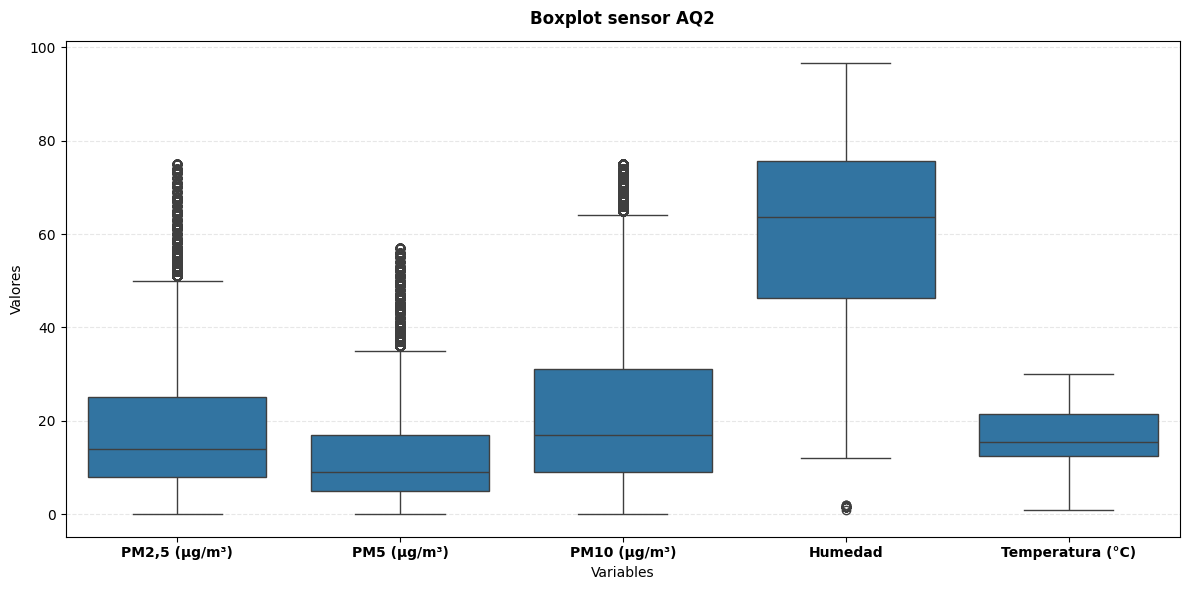

In [338]:
plot_all_boxplots(
    AQ2_CLEAN_F1,
    title="Boxplot sensor AQ2",
    column_order=["pm2_5", "pm5", "pm10", "humidity", "temperature"],
    xlabels=["PM2,5 (µg/m³)", "PM5 (µg/m³)", "PM10 (µg/m³)", "Humedad", "Temperatura (°C)"],
    rotate_xticks=0,
    bold_xticks=True
)


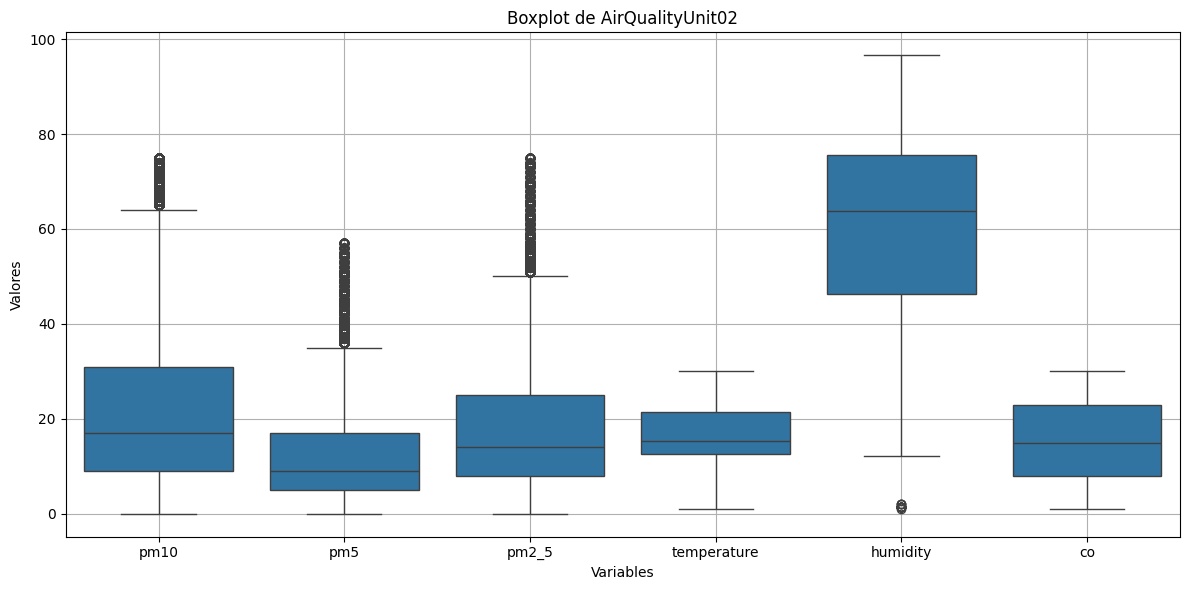

In [307]:
plot_all_boxplots(AQ2_CLEAN_F1, title="Boxplot de AirQualityUnit02",columns=['pm10', 'pm5','pm2_5','temperature','humidity','co'])


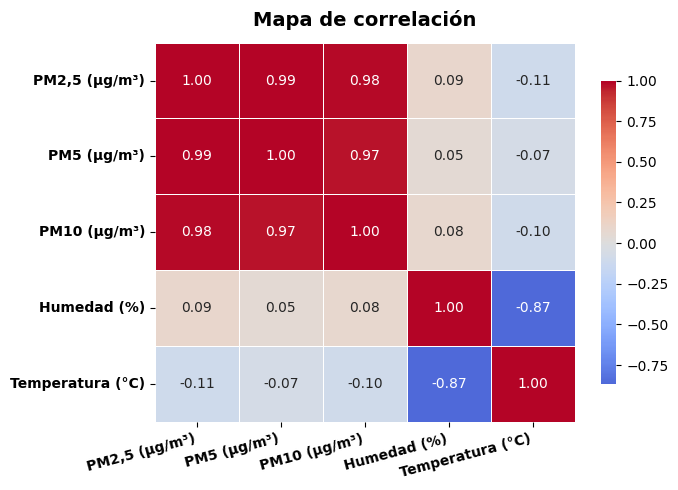

In [345]:
plot_correlation_map(
    AQ2_CLEAN_F1,
    cols=["pm2_5", "pm10", "pm5", "humidity", "temperature"],
    order=["pm2_5", "pm5", "pm10", "humidity", "temperature"],
    cmap="coolwarm",
    figsize=(7,5),
    xlabels=["PM2,5 (µg/m³)", "PM5 (µg/m³)", "PM10 (µg/m³)", "Humedad (%)", "Temperatura (°C)"],
    ylabels=["PM2,5 (µg/m³)", "PM5 (µg/m³)", "PM10 (µg/m³)", "Humedad (%)", "Temperatura (°C)"],
    xrotation=15  # casi horizontal
)


In [309]:
#DFAQ1_CPM2_5 = remove_outliers_and_plot_boxplot(DFAQ1, 'pm2_5',1.4)

In [310]:
#DFAQ1_CPM2_5_2 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5, 'pm10',1.5)

In [311]:
#DFAQ1_CPM2_5_3 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_2, 'pm5',1.5)

In [312]:
#DFAQ1_CPM2_5_4 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_3, 'temperature',1.5)

In [313]:
#DFAQ1_CPM2_5_5 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_4, 'humidity',1.4)

In [314]:
#DFAQ1_CPM2_5_6 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_5, 'co',1.5)

In [315]:
#DFAQ1_CPM2_5_7 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_6, 'o3',1.5)

In [316]:
DF_AQ1 = AQ1_CLEAN_F1
DF_AQ2 = AQ2_CLEAN_F1

/tmp/ipykernel_1180596/771816385.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=rotate_xticks, ha="center",


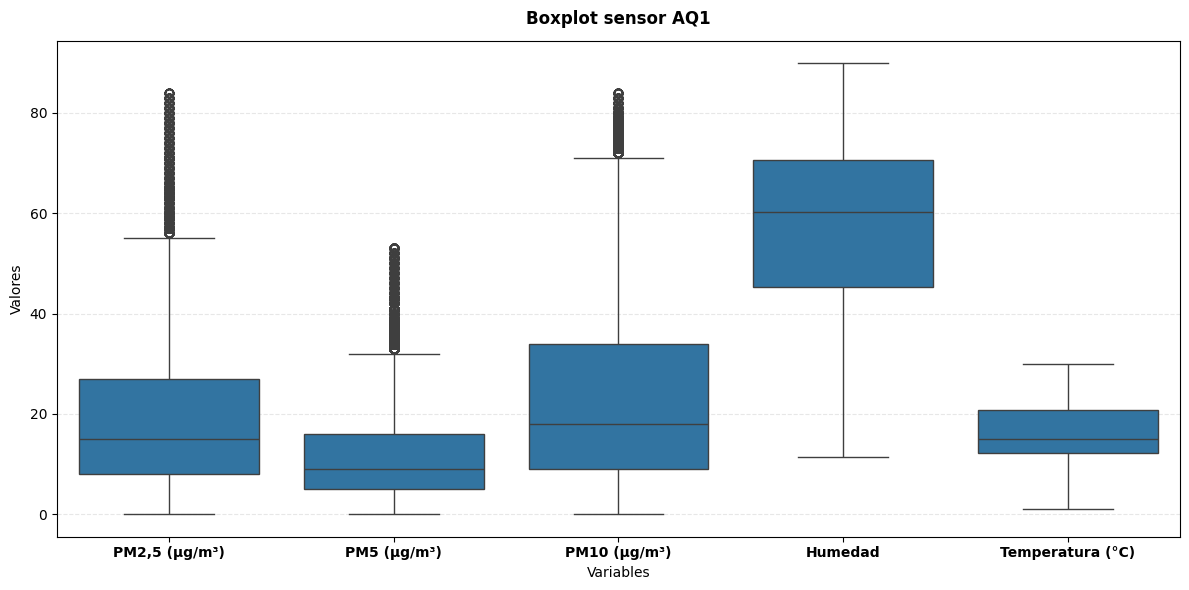

In [340]:
plot_all_boxplots(
    DF_AQ1,
    title="Boxplot sensor AQ1",
    column_order=["pm2_5", "pm5", "pm10", "humidity", "temperature"],
    xlabels=["PM2,5 (µg/m³)", "PM5 (µg/m³)", "PM10 (µg/m³)", "Humedad", "Temperatura (°C)"],
    rotate_xticks=0,
    bold_xticks=True
)


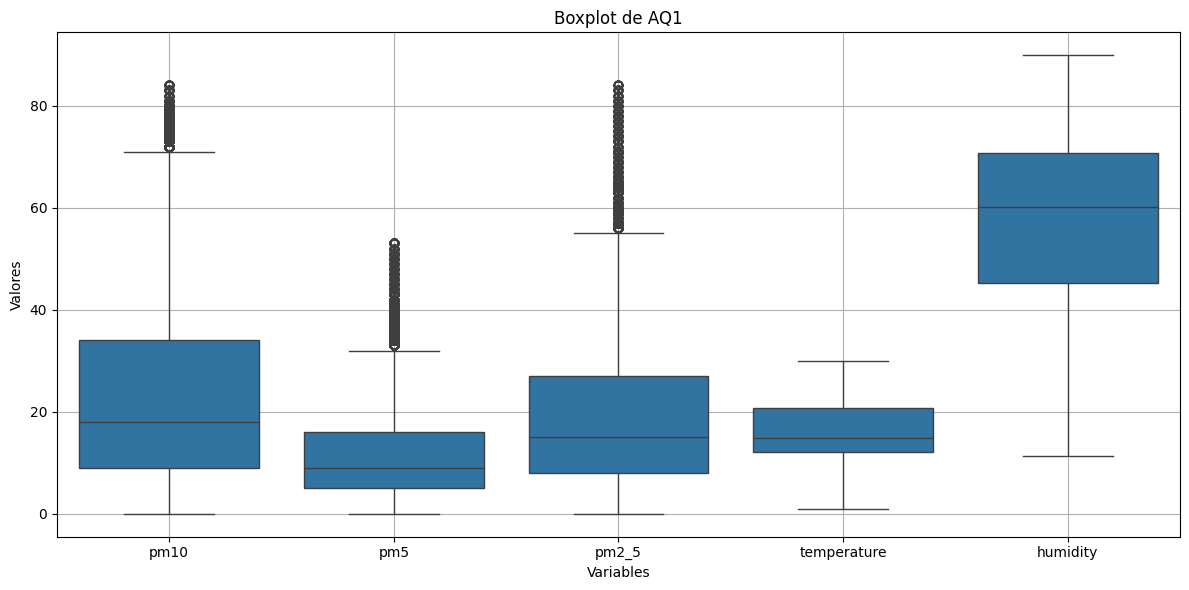

In [318]:
plot_all_boxplots(DF_AQ1, title="Boxplot de AQ1",columns=['pm10', 'pm5','pm2_5','temperature','humidity'])


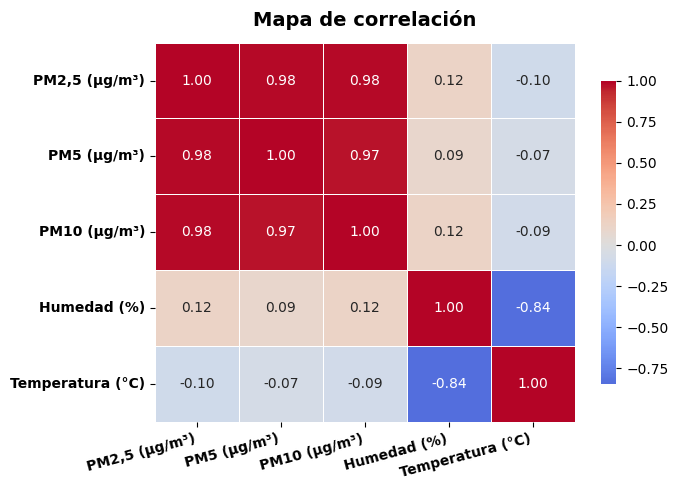

In [346]:
plot_correlation_map(
    AQ1_CLEAN_F1,
    cols=["pm2_5", "pm10", "pm5", "humidity", "temperature"],
    order=["pm2_5", "pm5", "pm10", "humidity", "temperature"],
    cmap="coolwarm",
    figsize=(7,5),
    xlabels=["PM2,5 (µg/m³)", "PM5 (µg/m³)", "PM10 (µg/m³)", "Humedad (%)", "Temperatura (°C)"],
    ylabels=["PM2,5 (µg/m³)", "PM5 (µg/m³)", "PM10 (µg/m³)", "Humedad (%)", "Temperatura (°C)"],
    xrotation=15  # casi horizontal
)


In [320]:
#DFAQSEP_CPM2_5 = remove_outliers_and_plot_boxplot(DFAQSEP, 'pm2_5',1.5)

In [321]:
#DFAQSEP_CPM2_5_1 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5, 'pm10',1.5)

In [322]:
#DFAQSEP_CPM2_5_2 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_1, 'co',1.5)

In [323]:
#DFAQSEP_CPM2_5_3 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_2, 'humidity',1.5)

In [324]:
#DFAQSEP_CPM2_5_4 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_3, 'temperature',1.5)

In [325]:
#DFAQSEP_CPM2_5_5 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_4, 'o3',1.5)

In [326]:
DF_AQSEP = AQSEP_CLEAN_F1

/tmp/ipykernel_1180596/771816385.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=rotate_xticks, ha="center",


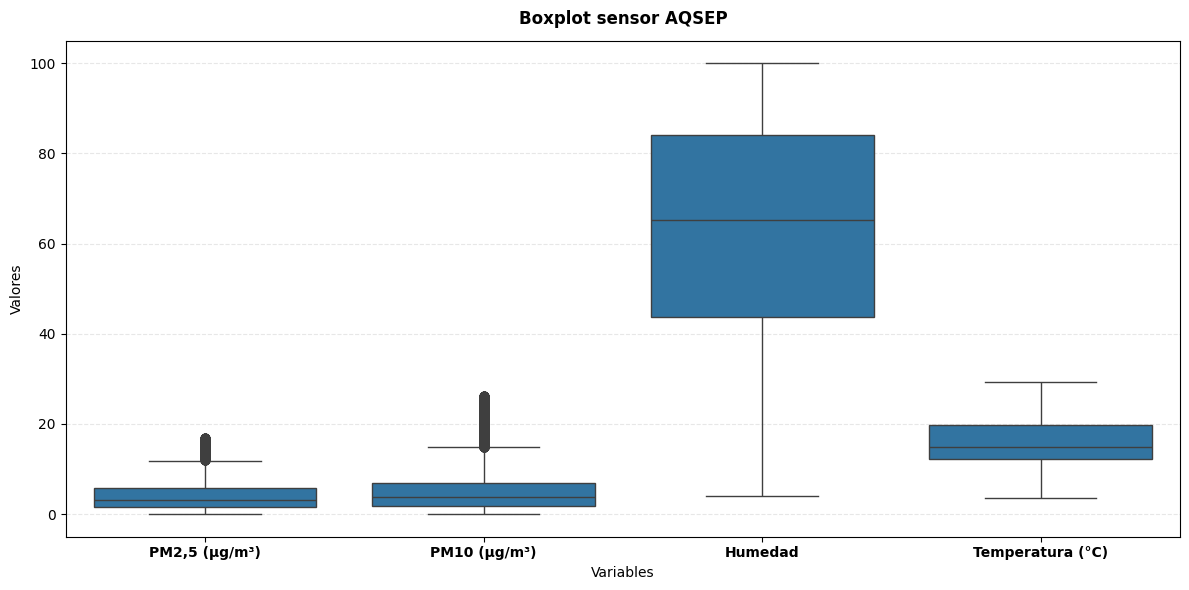

In [341]:
plot_all_boxplots(
    DF_AQSEP,
    title="Boxplot sensor AQSEP",
    column_order=["pm2_5", "pm10", "humidity", "temperature"],
    xlabels=["PM2,5 (µg/m³)", "PM10 (µg/m³)", "Humedad", "Temperatura (°C)"],
    rotate_xticks=0,
    bold_xticks=True
)


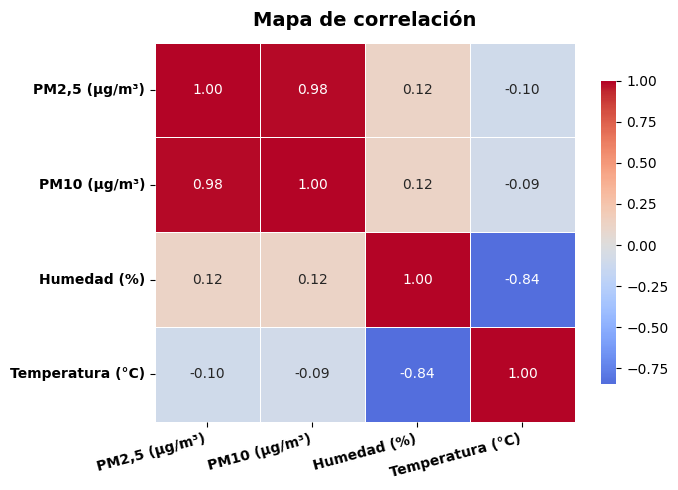

In [347]:
plot_correlation_map(
    AQ1_CLEAN_F1,
    cols=["pm2_5", "pm10", "humidity", "temperature"],
    order=["pm2_5", "pm10", "humidity", "temperature"],
    cmap="coolwarm",
    figsize=(7,5),
    xlabels=["PM2,5 (µg/m³)","PM10 (µg/m³)", "Humedad (%)", "Temperatura (°C)"],
    ylabels=["PM2,5 (µg/m³)", "PM10 (µg/m³)", "Humedad (%)", "Temperatura (°C)"],
    xrotation=15  # casi horizontal
)


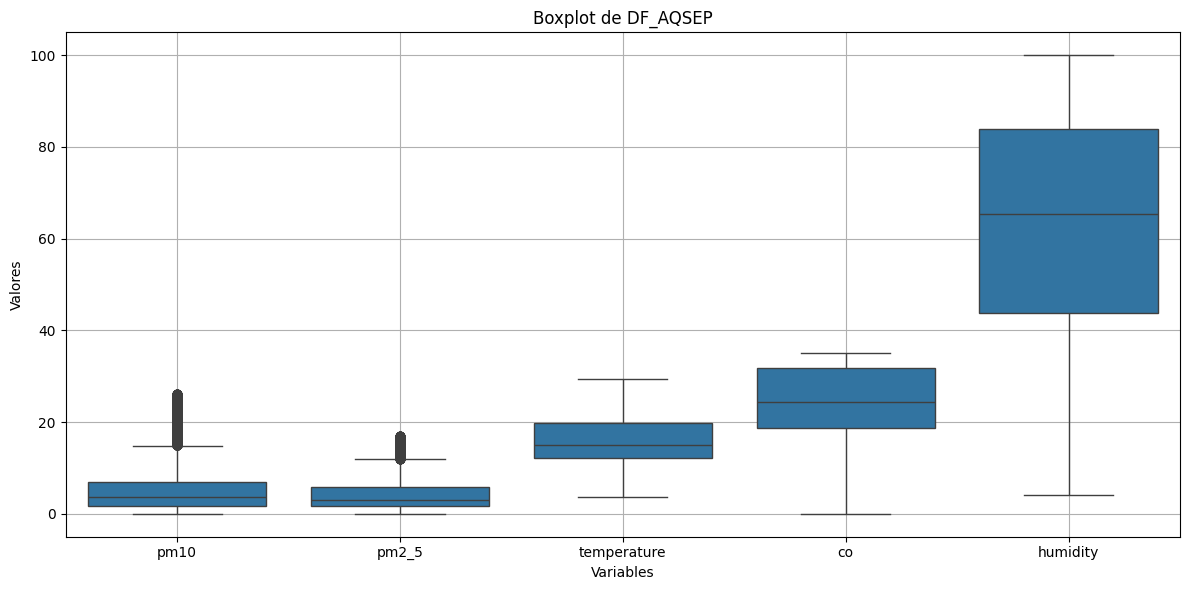

In [329]:
plot_all_boxplots(DF_AQSEP, title="Boxplot de DF_AQSEP",columns=['pm10','pm2_5', 'temperature', 'co', 'humidity'])

In [330]:
DF_AQ2_resampled = resample_dataframe_by_time(DF_AQ2, time_column='time_format', freq='H', agg_func='median')
DF_AQ1_resampled = resample_dataframe_by_time(DF_AQ1, time_column='time_format', freq='H', agg_func='median')
DF_AQSEP_resampled = resample_dataframe_by_time(DF_AQSEP, time_column='time_format', freq='H', agg_func='median')

/tmp/ipykernel_1180596/737887448.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_copy.resample(freq).median()
/tmp/ipykernel_1180596/737887448.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_copy.resample(freq).median()
/tmp/ipykernel_1180596/737887448.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_copy.resample(freq).median()
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/air2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/air2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=k

In [331]:
print(DF_AQ2_resampled.head())
print(DF_AQ1_resampled.head())
print(DF_AQSEP_resampled.head())

                     pm2_5  pm10    co   o3  humidity  temperature  pm5
time_format                                                            
2023-06-28 00:00:00   13.0  22.5  15.5  0.0     81.30         11.1  6.0
2023-06-28 01:00:00   10.0  13.0  12.5  0.0     83.95         10.9  5.0
2023-06-28 02:00:00   11.0  13.0  14.0  0.0     83.70         10.4  6.0
2023-06-28 03:00:00   13.0  21.0  17.0  0.0     85.80         10.4  6.0
2023-06-28 04:00:00   17.0  24.0  16.0  0.0     85.60         10.1  9.0
                     pm2_5  pm10    co   o3  humidity  temperature   pm5
time_format                                                             
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.2         11.6   5.0
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5   9.0
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0   8.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7  10.0
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3     

In [332]:
#DF_AQ1_resampled.count()
#DF_AQ2_resampled.count()
#DF_AQSEP_resampled.count()

In [333]:
def create_and_insert_resampled_tables(dataframes_dict):
    """
    Crea tablas en la base de datos si no existen y luego inserta los datos resampleados.

    Parámetros:
        dataframes_dict (dict): Diccionario con clave como nombre de la tabla y valor el DataFrame

    Retorna:
        None
    """
    if engine is None:
        raise Exception("⚠️ Debes ejecutar primero `connect_to_db()` para establecer la conexión.")

    inspector = inspect(engine)

    for table_name, df in dataframes_dict.items():
        try:
            # Verificar si la tabla ya existe
            if table_name in inspector.get_table_names():
                print(f"ℹ️ La tabla '{table_name}' ya existe. No se creó ni sobrescribió.")
            else:
                # Crear tabla e insertar datos
                df.to_sql(name=table_name, con=engine, if_exists='fail', index=True)
                print(f"✅ Tabla '{table_name}' creada y datos insertados ({len(df)} registros).")
        except Exception as e:
            print(f"❌ Error en la tabla '{table_name}': {e}")


In [334]:
resampled_dfs = {
    "DF_AQ2_RESAMPLED": DF_AQ2_resampled,
    "DF_AQ1_RESAMPLED": DF_AQ1_resampled,
    "DF_AQSEP_RESAMPLED": DF_AQSEP_resampled
}

create_and_insert_resampled_tables(resampled_dfs)


✅ Tabla 'DF_AQ2_RESAMPLED' creada y datos insertados (9936 registros).
✅ Tabla 'DF_AQ1_RESAMPLED' creada y datos insertados (9936 registros).
✅ Tabla 'DF_AQSEP_RESAMPLED' creada y datos insertados (9936 registros).
